In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sklearn
import sklearn.datasets

from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()


In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2

In [3]:
#корреляция которых более ``threshold``
def corr_feature_detect(data, threshold=0.6):    
    corrmat = data.corr()
    corrmat = corrmat.abs().unstack() 
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1] 
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
    
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(correlated_block.feature2.unique()) + [feature]
    
            correlated_groups.append(correlated_block)
    return pd.concat(correlated_groups, sort=False)

Цель: 
В этом домашнем задании вам предстоит провести детективную работу и узнать, какой же алгоритм бустинга работает лучше всего (конечно, применительно к конкретной задаче)
Источник данных:https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data

In [4]:
#Загрузка
data = pd.read_csv('WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')

Анализ данных

In [5]:
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [6]:
data.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

Преобразование данных

In [8]:
#Целевая переменная не число, надо преобразовать
data['Response'] = data['Response'].apply(lambda x: 1 if x == 'Yes' else 0)

In [9]:
#Средний уровень лояльности
data['Response'].mean()

0.14320122618786948

In [10]:
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,0,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,0,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,0,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,0,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,0,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [11]:
#Проверим дубликаты
sum(data['Customer'].duplicated())

0

In [12]:
#Пустые значения
data.isnull().sum()

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

In [13]:
corr_feature_detect(data=data, threshold=0.6)
#Неожиданная странная кореляция

,feature1,feature2,corr
0,Monthly Premium Auto,Total Claim Amount,0.632017


In [14]:
#попробуйте добавить новые переменные
data['Effective To Date'] = pd.to_datetime(data['Effective To Date'])
max_date = pd.to_datetime(data['Effective To Date']).max()

In [15]:
print(max_date)

2011-02-28 00:00:00


In [16]:
#Предположим, что чем больше дней прошло с последней активности , тем хуже 
#Пока посчитаем дней с последней активности
data['days_from_effective'] = (max_date - data['Effective To Date']).dt.days
data.drop(['Effective To Date'], axis=1, inplace=True)

In [17]:
data.describe()

,Customer Lifetime Value,Response,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,days_from_effective
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,0.143201,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,29.162251
std,6870.967608,0.350297,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,16.942769
min,1898.007675,0.000000,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,0.000000
25%,3994.251794,0.000000,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,15.000000
50%,5780.182197,0.000000,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,30.000000
75%,8962.167041,0.000000,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,44.000000
max,83325.381190,1.000000,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,58.000000


In [18]:
# и выкинуть лишние. Уберем не информативные переменные
data.drop(['Customer'], axis="columns", inplace=True)

In [19]:
#Не числовые переменные
objs = data.select_dtypes(include=['object'])
print('Objects: {}'.format(objs.shape))
objs.head(4)

Objects: (9134, 13)


,State,Coverage,Education,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
0,Washington,Basic,Bachelor,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,Arizona,Extended,Bachelor,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,Nevada,Premium,Bachelor,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize
3,California,Basic,Bachelor,Unemployed,M,Suburban,Married,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize


In [20]:
continuous_features = data.select_dtypes(exclude=['object'])
continuous_features.head()

,Customer Lifetime Value,Response,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,days_from_effective
0,2763.519279,0,56274,69,32,5,0,1,384.811147,4
1,6979.535903,0,0,94,13,42,0,8,1131.464935,28
2,12887.431650,0,48767,108,18,38,0,2,566.472247,9
3,7645.861827,0,0,106,18,65,0,7,529.881344,39
4,2813.692575,0,43836,73,12,44,0,1,138.130879,25


<Figure size 2160x2160 with 0 Axes>

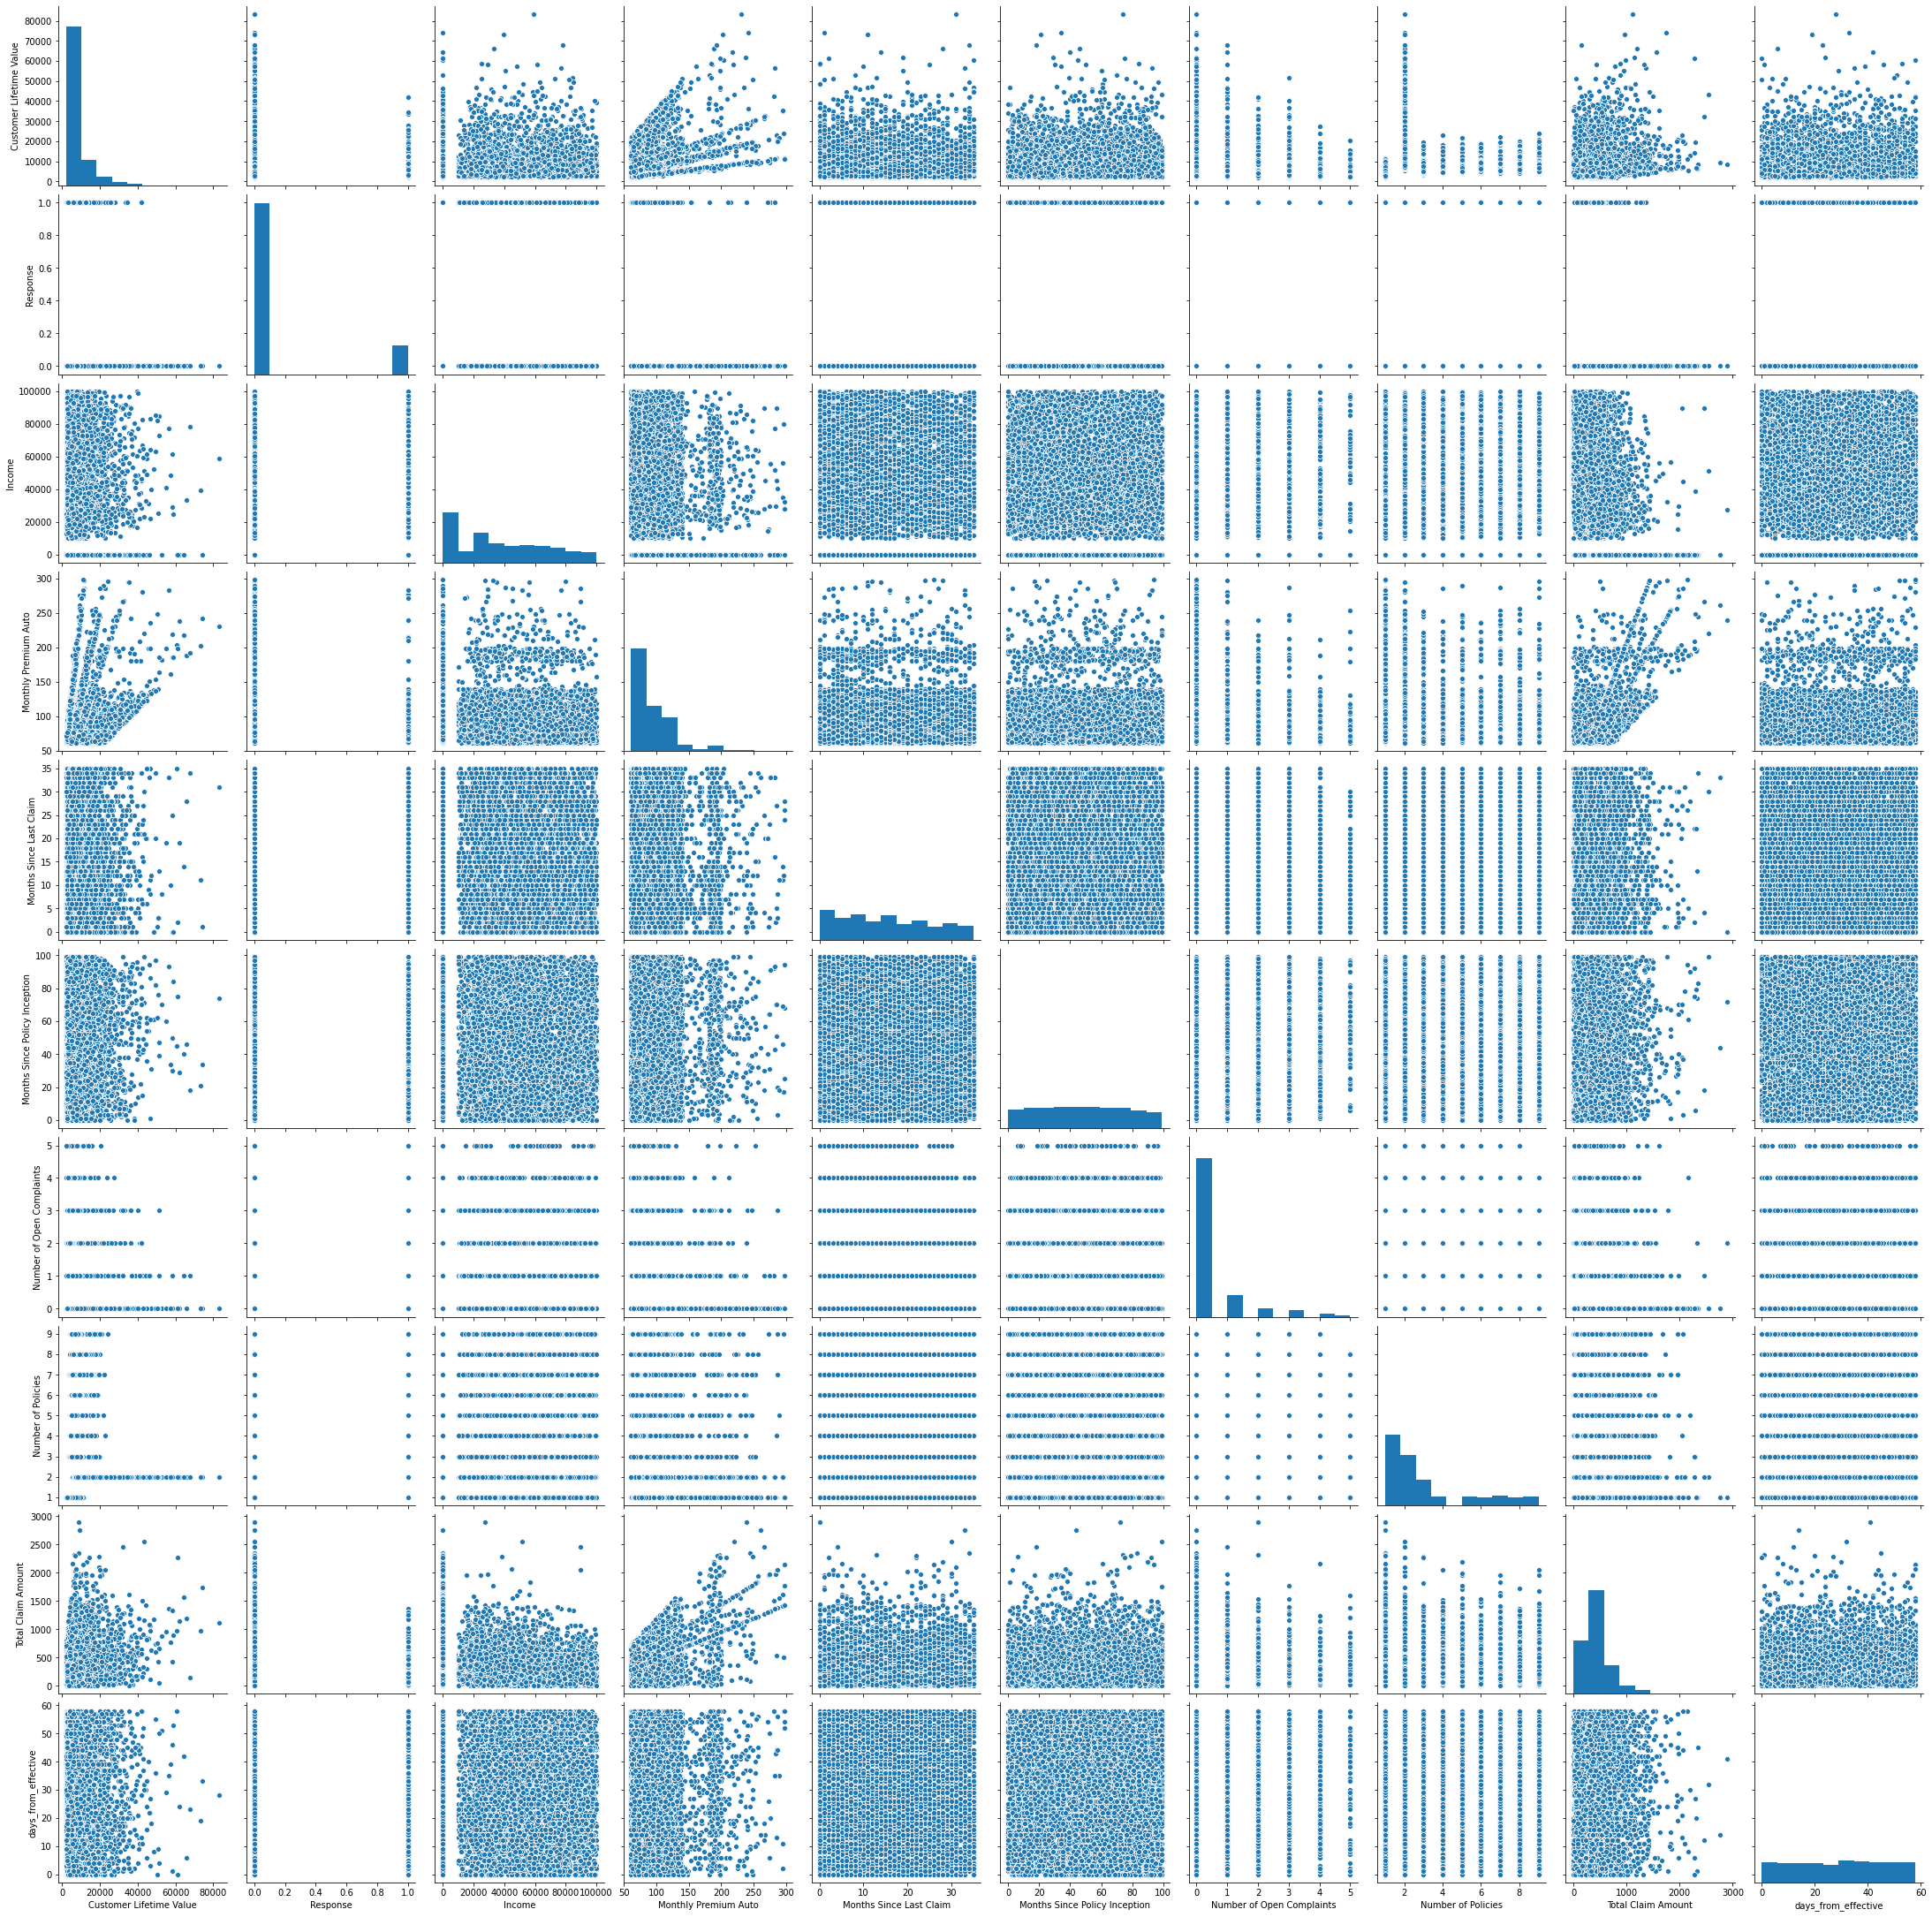

In [21]:
#pair plots
plt.figure(figsize=(30, 30))
sns.pairplot(continuous_features, height=3, diag_kind="hist")

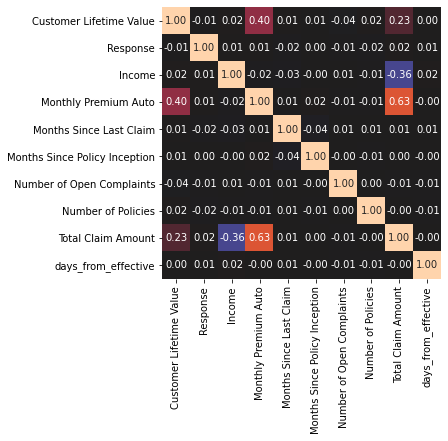

In [22]:
#Кореляция
plt.figure(figsize=(5,5))
sns.heatmap(continuous_features.corr(), annot=True, fmt='.2f', cbar=False, center=0);

In [23]:
#Посмотрим на признаки с типом object
categorical_col = []
for data_o in objs:
    categorical_col.append(data_o)
    print(data_o + ':')
    print(data[data_o].value_counts())
    print()

State:
California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: State, dtype: int64

Coverage:
Basic       5568
Extended    2742
Premium      824
Name: Coverage, dtype: int64

Education:
Bachelor                2748
College                 2681
High School or Below    2622
Master                   741
Doctor                   342
Name: Education, dtype: int64

EmploymentStatus:
Employed         5698
Unemployed       2317
Medical Leave     432
Disabled          405
Retired           282
Name: EmploymentStatus, dtype: int64

Gender:
F    4658
M    4476
Name: Gender, dtype: int64

Location Code:
Suburban    5779
Rural       1773
Urban       1582
Name: Location Code, dtype: int64

Marital Status:
Married     5298
Single      2467
Divorced    1369
Name: Marital Status, dtype: int64

Policy Type:
Personal Auto     6788
Corporate Auto    1968
Special Auto       378
Name: Policy Type, dtype: int64

Policy:
Personal L3     3426
Personal L2     2122
Pe

In [24]:
#Категориальные переменные 
#dummy data = pd.get_dummies(data, columns=categorical_col)
# Переведите категориальные переменные в уникальные лейблы при помощи LabelEncoder
for column_cat in categorical_col:
    label.fit(data[column_cat].drop_duplicates())
    data[column_cat] = label.transform(data[column_cat])

In [25]:
data.head()

,State,Customer Lifetime Value,Response,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,days_from_effective
0,4,2763.519279,0,0,0,1,0,56274,1,1,...,0,1,0,2,0,0,384.811147,5,1,4
1,0,6979.535903,0,1,0,4,0,0,1,2,...,0,8,1,5,2,0,1131.464935,0,1,28
2,2,12887.431650,0,2,0,1,0,48767,1,1,...,0,2,1,5,0,0,566.472247,5,1,9
3,1,7645.861827,0,0,0,4,1,0,1,1,...,0,7,0,1,0,2,529.881344,3,1,39
4,4,2813.692575,0,0,0,1,1,43836,0,2,...,0,1,1,3,0,0,138.130879,0,1,25


In [26]:
data.count()

State                            9134
Customer Lifetime Value          9134
Response                         9134
Coverage                         9134
Education                        9134
EmploymentStatus                 9134
Gender                           9134
Income                           9134
Location Code                    9134
Marital Status                   9134
Monthly Premium Auto             9134
Months Since Last Claim          9134
Months Since Policy Inception    9134
Number of Open Complaints        9134
Number of Policies               9134
Policy Type                      9134
Policy                           9134
Renew Offer Type                 9134
Sales Channel                    9134
Total Claim Amount               9134
Vehicle Class                    9134
Vehicle Size                     9134
days_from_effective              9134
dtype: int64

In [27]:
#разбейте данные на train-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Response'], axis=1), data['Response'], test_size=0.3, random_state=0)

In [28]:
ac = dict()
m_s_e = dict()

Постройте 4 варианта градиентного бустинга, используя значения гиперпараметров “из коробки”: реализация из sklearn, XGBoost, CatBoost, LightGBM


In [29]:
#реализация из sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import mean_squared_error
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [30]:
# Оценка прогноза
predictions = [round(value) for value in y_pred]
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
ac['GradientBoostingRegressor'] = accuracy * 100.0
m_s_e['GradientBoostingRegressor'] = mean_squared_error(y_test, predictions)

Accuracy: 87.05%


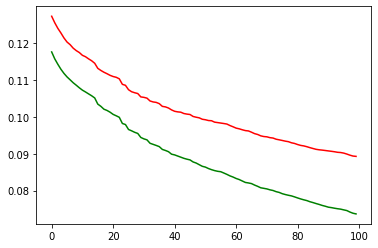

In [31]:
test_score = np.empty(len(model.estimators_))
for i, pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, pred)
plt.plot(test_score, label='Test', color='red')
plt.plot(model.train_score_, label='Train', color='green')

In [32]:
#XGBoost
import xgboost
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)
# Предсказание на тесте
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# Оценка прогноза
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
ac['XGBRegressor'] = accuracy * 100.0
m_s_e['XGBRegressor'] = mean_squared_error(y_test, predictions)

Accuracy: 87.01%


In [33]:
#CatBoost
from catboost import CatBoostRegressor
model = CatBoostRegressor()
model.fit(X_train, y_train)
# Предсказание на тесте
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

Learning rate set to 0.054302
0:	learn: 0.3432956	total: 47.9ms	remaining: 47.8s
1:	learn: 0.3407947	total: 49.5ms	remaining: 24.7s
2:	learn: 0.3387715	total: 51.2ms	remaining: 17s
3:	learn: 0.3361065	total: 57.2ms	remaining: 14.2s
4:	learn: 0.3344029	total: 60ms	remaining: 11.9s
5:	learn: 0.3327265	total: 62.3ms	remaining: 10.3s
6:	learn: 0.3307320	total: 63.8ms	remaining: 9.04s
7:	learn: 0.3294909	total: 65.2ms	remaining: 8.09s
8:	learn: 0.3282436	total: 66.7ms	remaining: 7.35s
9:	learn: 0.3267596	total: 72.6ms	remaining: 7.19s
10:	learn: 0.3256662	total: 74.3ms	remaining: 6.68s
11:	learn: 0.3238722	total: 75.8ms	remaining: 6.24s
12:	learn: 0.3221194	total: 77.4ms	remaining: 5.88s
13:	learn: 0.3207355	total: 78.9ms	remaining: 5.56s
14:	learn: 0.3197298	total: 80.4ms	remaining: 5.28s
15:	learn: 0.3186658	total: 86.9ms	remaining: 5.34s
16:	learn: 0.3173106	total: 88.8ms	remaining: 5.14s
17:	learn: 0.3160446	total: 90.5ms	remaining: 4.93s
18:	learn: 0.3154268	total: 91.9ms	remaining: 4.

In [34]:
# Оценка прогноза
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
ac['CatBoostRegressor'] = accuracy * 100.0
m_s_e['CatBoostRegressor'] = mean_squared_error(y_test, predictions)

Accuracy: 97.96%


In [35]:
#LightGBM
import lightgbm as lgbm
d_train=lgbm.Dataset(X_train, label=y_train)
clf=lgbm.train({},d_train)
# Предсказание на тесте
y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]
# Оценка прогноза
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
ac['LightGBM'] = accuracy * 100.0
m_s_e['LightGBM'] = mean_squared_error(y_test, predictions)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 6393, number of used features: 22
[LightGBM] [Info] Start training from score 0.139215
Accuracy: 95.66%


In [36]:
#Проверьте качество на отложенной выборке, кто пока лидирует?
print('ACCURACY')
print(ac)
print('MSE')
print(m_s_e)
#Пока лидирует CatBoostRegressor

ACCURACY
{'GradientBoostingRegressor': 87.04852243706677, 'XGBRegressor': 87.01203940167822, 'CatBoostRegressor': 97.95695001824151, 'LightGBM': 95.65851878876323}
MSE
{'GradientBoostingRegressor': 0.12951477562933236, 'XGBRegressor': 0.1298796059832178, 'CatBoostRegressor': 0.020430499817584824, 'LightGBM': 0.04341481211236775}


In [37]:
#Теперь проведите настройку гиперпараметров моделей на кросс-валидации, 
#можно настраивать только самые основные гиперпараметры - число итераций бустинга, max_features, subsample и т.д.

Hyperopt¶

Hyperopt is a python library for Bayesian optimization of hyperparameters:

It has better overall performance and takes less time than grid search and random search methods.
I prefer the api for hyperopt to sklearn's gridsearch. It's more flexible and easy to integrate with various machine learning models.

Hyperopt works by treating the search of hyperparameters as an optimization task where it uses the returned loss from the objective function, fit_model(parameters), to decide what the next set of hyperparameters should be. Hyperparameter search spaces are generally large multi-dimensional spaces so hyperopt is a big improvement over grid and random search, especially as the search space expands.

Hyperopt has a few components:

Objective function. 
This is where we put our ml model and what we pass our hyperparameters into. The objective function will return at a minimum, the loss- more complex designs will return an object which can have various fields.

Feature space. 
The feature space is an object that gets passed to our objective function. The hp object in hyperopt has many functions for constructing ranges and distributions for our features.

Trials object. 
This is not strictly necessary but the Trials object allows us to store all the values that we returned from our experiment.

fmin function. 
This is the function that minimizes our objective. fmin takes our object, space, trials, and the max amount of evaluations, max_evals.

XGBoost

General Parameters

Booster (default=gbtree): Type of model to run at each iteration (gbtree= tree-based, gblinear=linear model)
silent (defualt=0): Set to True to aviod printing updates with each cycle.
nthread (default= max available): Number of threads for parallel processing.

Tree Booster Parameters

eta (default=0.3): Aliased as learning rate, typical values- 0.01-0.3
min_child_weight (default=1): Defines the minimum sum of the weights of all observations required in child. Used to control overfitting, high values can lead to underfitting.
max_depth (default=6): Higher depth allows learned relations very specific to a particular sample. Typical values are 3-10.
gamma (default=0): Minimum loss reduction required to partition on a leaf node of a tree- the larger gamma the more conservative the algorithm.
max_delta_step (default=0): Maximum delta step we allow each leaf output to be. This is generally not used but might help in logistic regression when the class is extremely imbalanced.
subsample (default=1): Subsample ratio of the training instances, if 0.5 XGBoost would randomly sample half of the training data prior to growing trees, and this will prevent overfitting.
colsample_bytree (default=1): Denotes the fraction of features to use.
colsample_bylevel (defualt=1): Denotes the fraction of features but in terms of the level rather than tree.
lambda (default=1): L2 regularization parameter.
alpha (defualt=0): : L1 regularization parameter.
scale_pos_weight (default=1): Controls the balance of positive and negative weights, its useful for unbalanced classes.

Learning Task Parameters

These parameters define the optimization objective to be calculated at each step.

objective (default=linear): The loss function, logistic, softmax, and softprob (same as softmax but returns predicted probabilites not predicted classes).
eval_metric (default based on objective): The metric used to validate data like: rmse, mae, logloss, error(binary classification), merror (multiclass error), mlogloss, auc (area under the curve).

num_boosting_rounds: This is passed to .train() and .cv(). For each round in the results we will see our mean and standard dev of the evaluation metric. Fitting a model with fit() will instead use n_estimators.


LightGBM

LightGBM is an open-source GBDT framework created by Microsoft as a fast and scalable alternative to XGB and GBM. By default LightGBM will train a Gradient Boosted Decision Tree (GBDT), but it also supports random forests, Dropouts meet Multiple Additive Regression Trees (DART), and Gradient Based One-Side Sampling (Goss).

Tree Parameters

max_depth: The maximum depth of the tree, this is used to handle model overfitting. If the model is overfitting lowering max_depth should be the first thing to change.
min_data_in_leaf (default=20): The mininmum number of records a leaf may have, helps with overfitting. Setting it to a large value can avoid growing too deep a tree, but may cause underfitting. Setting it to hundreds or thousands is enough in a large dataset.
feature_fraction: The fraction of the features randomly sampled from when building trees, a familiar parameter in GBDts.
bagging_fraction: Specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting.
early_stopping_round: Model will stop training if the validation metric doesn't improve for consecutive rounds.
lambda: Specifies regularization, typical values 0-1.
min_gain_to_split: This parameter will describe the minimum gain to make a split.

General Parameters

Application:
regression: Regression
binary: Binary classification
multiclass: Multiclass classification
Boosting:
gdbt: Gradient Boosted Decision Tree
rf: Random Forest
dart: Dropouts meet multiple regression trees
goss: Gradient-based One-Side Sampling
num_boost_round: Number of boosting iterations, typically 100+
learning_rate: This determines the impact of each tree on the final outcome. Typical values 0.1, 0.001, 0.003
num_leaves (default=31): Number of leaves in full tree. This is the main parameter to control the complexity of the model. Ideally, the value of num_leaves should be less than or equal to 2^ (max_depth). Value more than this will result in overfitting.

Metric Parameter:
Mae
Mse
Binary_logloss
Multi_logloss
categorical_feature: It denotes the index of categorical features.

In [42]:
#создать класс HPOpt
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials
    
    def gb_reg(self, para):
        reg = GradientBoostingRegressor(**para['reg_params'])
        return self.train_reg(reg, para)


    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [143]:
from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error


# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     hp.choice('iterations', np.arange(500, 1000, 2000)),
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.uniform('learning_rate',    0.01, 0.1),
    'colsample_bytree':  hp.uniform('colsample_bytree', 0.1, 1),
    'subsample':        hp.uniform('subsample', 0.5, 1),
    'n_estimators':     hp.choice('iterations', np.arange(500, 1000, 2000)),
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.uniform('learning_rate',    0.01, 0.1),
    'max_depth':         hp.choice('max_depth',        np.arange(6, 10, dtype=int)),
    'colsample_bylevel': hp.uniform('colsample_bytree', 0.1, 1),
    'iterations':        hp.choice('iterations', np.arange(500, 1000, 2000)),
    'subsample':         hp.uniform('subsample', 0.5, 1),
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [144]:
#Снова проверьте качество уже настроенных моделей, кто, в итоге победил?
obj = HPOpt(X_train, X_test, y_train, y_test)
#print('gb_reg')
#gb_opt = obj.process(fn_name='gb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
print('xgb_reg')
xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
print('lgb_reg')
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)
print('cgb_reg')
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)


xgb_reg
100%|██████████| 100/100 [05:47<00:00,  3.47s/trial, best loss: 0.06974631976581955]
lgb_reg
100%|██████████| 100/100 [01:30<00:00,  1.11trial/s, best loss: 0.11600268669138293]
cgb_reg
100%|██████████| 100/100 [03:28<00:00,  2.09s/trial, best loss: 0.10189057188403933]


In [ ]:
#Победил xgb_reg по точности и LightGBM по скорости